# Setup lib

In [ ]:
# Common imports
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
#import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import os 
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor 
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    try:
        plt.savefig(path, format=fig_extension, dpi=resolution)
    except:
        plt.savefig(fig_id + "." + fig_extension, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
pd.options.display.max_columns = None


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preparation for Modeling

In [ ]:
listings = pd.read_csv('/content/drive/MyDrive/airbnb/listings_processed.csv')

In [ ]:
listings.shape

(56708, 43)

In [ ]:
listings.columns

Index(['host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'host_days_active',
       'balcony', 'bed_linen', 'tv', 'coffee_machine', 'cooking_basics',
       'white_goods', 'child_friendly', 'parking', 'host_greeting', 'internet',
       'long_term_stays', 'private_entrance', 'time_since_first_review',
       'time_since_last_review'],
      dtype='object')

In [ ]:
listings = listings.drop(list(listings.columns[listings.columns.str.startswith('neighbourhood')]), axis=1)

In [ ]:
transformed_df= pd.get_dummies(listings)

In [ ]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


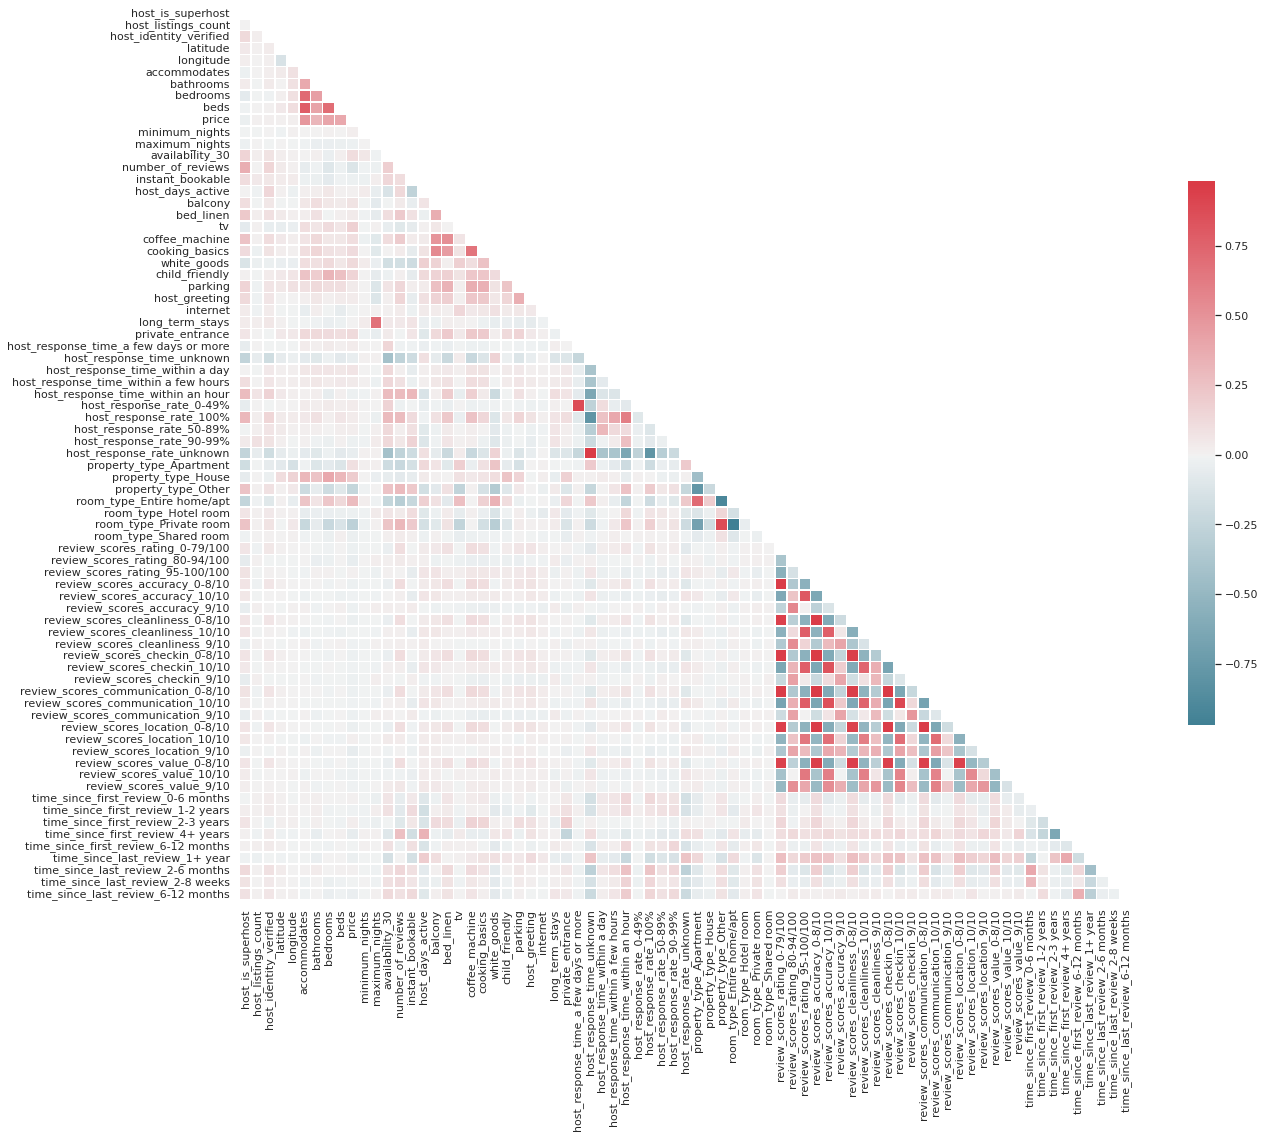

In [ ]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

In [ ]:
transformed_df.columns

Index(['host_is_superhost', 'host_listings_count', 'host_identity_verified',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'number_of_reviews', 'instant_bookable', 'host_days_active', 'balcony',
       'bed_linen', 'tv', 'coffee_machine', 'cooking_basics', 'white_goods',
       'child_friendly', 'parking', 'host_greeting', 'internet',
       'long_term_stays', 'private_entrance',
       'host_response_time_a few days or more', 'host_response_time_unknown',
       'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'host_response_rate_0-49%',
       'host_response_rate_100%', 'host_response_rate_50-89%',
       'host_response_rate_90-99%', 'host_response_rate_unknown',
       'property_type_Apartment', 'property_type_House', 'property_type_Other',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Pr

## Drop features

In [ ]:
# Dropping collinear features
to_drop = ['latitude',
           'longitude',
           'beds',
           'host_response_time_a few days or more']

transformed_df.drop(to_drop, axis=1, inplace=True)

## Power Transform

https://machinelearningmastery.com/power-transforms-with-scikit-learn/

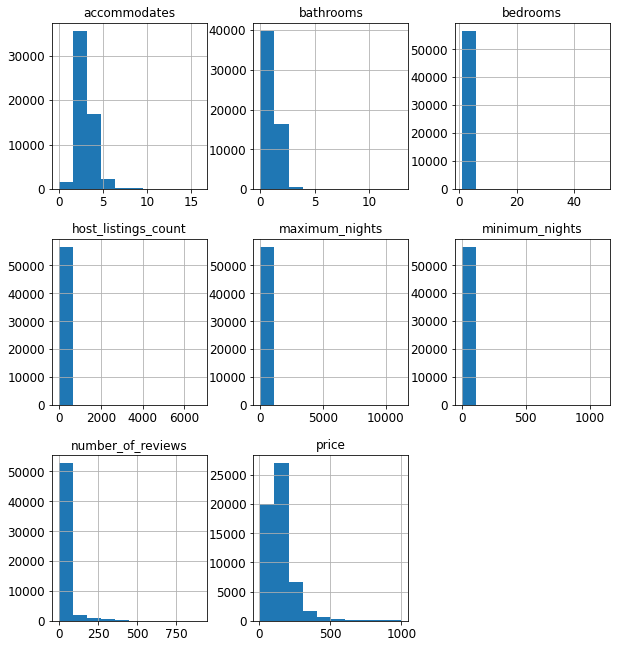

In [ ]:
numerical_columns = ['accommodates', 'bathrooms', 
                     'bedrooms',
                     'host_listings_count',
                     'maximum_nights', 'minimum_nights',                  
                     'number_of_reviews','price']
                     
for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64')
    
transformed_df[numerical_columns].hist(figsize=(10,11));

In [ ]:
transformed_df.to_csv('transformed_df.csv',index=False)

In [ ]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')

transformed_df[numerical_columns] = pt.fit_transform(transformed_df[numerical_columns])

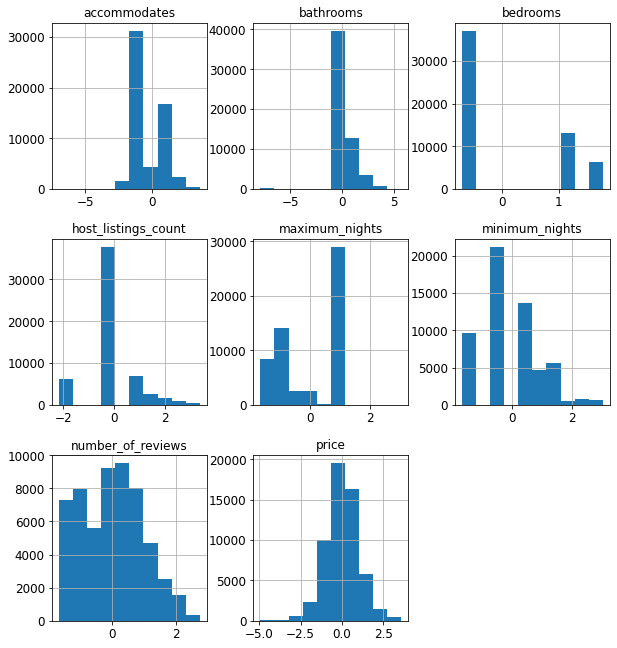

In [ ]:
transformed_df[numerical_columns].hist(figsize=(10,11));

## Standarization Data

In [ ]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [ ]:
print(X.shape)
print(y.shape)

(56708, 72)
(56708,)


In [ ]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)
print(X_test.shape)

(45366, 70)
(45366,)
(11342,)
(11342, 70)


# Model Selection & Training

## XGBoost

In [ ]:
from sklearn.metrics import accuracy_score
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Testing MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Testing r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

[09:02:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.2 minutes

Training MSE: 0.495
Testing MSE: 0.5191

Training r2: 0.503
Testing r2: 0.489


In [ ]:
xgb_scores = (-cross_val_score(xgb_reg, X_train, y_train,cv=10, scoring='neg_mean_absolute_error'))
xgb_scores.mean()

[09:03:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:04:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

0.5325098963339373

## SVM Regressor

In [ ]:
from sklearn.svm import LinearSVR

svr_reg_start = time.time()
svr = LinearSVR(max_iter=10000)

svr.fit(X_train, y_train)
#predicting on the train set
y_pred_train = svr.predict(X_train)
y_pred_test = svr.predict(X_test)

svr_reg_end = time.time()

print(f"Time taken to run: {round((svr_reg_end - svr_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, y_pred_train),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_pred_test),4))
print("\nTraining r2:", round(r2_score(y_train, y_pred_train),4))
print("Validation r2:", round(r2_score(y_test, y_pred_test),4))

Time taken to run: 0.9 minutes

Training MSE: 0.5476
Validation MSE: 0.5618

Training r2: 0.4502
Validation r2: 0.4469


In [ ]:
svr_scores = (-cross_val_score(svr, X_train, y_train,cv=10, scoring='neg_mean_absolute_error'))
svr_scores.mean()

0.5537960968896891

## Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

#instantiate
gbrt_reg_start = time.time()

gbrt = GradientBoostingRegressor()

gbrt.fit(X_train, y_train)

# train set
y_pred_train = gbrt.predict(X_train)
y_pred_test = gbrt.predict(X_test)

gbrt_reg_end = time.time()

print(f"Time taken to run: {round((gbrt_reg_end - gbrt_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, y_pred_train),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_pred_test),4))
print("\nTraining r2:", round(r2_score(y_train, y_pred_train),4))
print("Validation r2:", round(r2_score(y_test, y_pred_test),4))

Time taken to run: 0.2 minutes

Training MSE: 0.4941
Validation MSE: 0.5187

Training r2: 0.5039
Validation r2: 0.4893


In [ ]:
gbrt_scores = (-cross_val_score(gbrt, X_train, y_train,cv=10, scoring='neg_mean_absolute_error'))
gbrt_scores.mean()

0.5325648031856891

## Random Forest Regressor

In [ ]:
# Istantiate

forest_reg_start = time.time()
forest_reg = RandomForestRegressor(n_jobs=-1) 
# Fit
forest_reg.fit(X_train, y_train)
# predict on the train set
y_pred_train = forest_reg.predict(X_train)
y_pred_test = forest_reg.predict(X_test)

forest_reg_end = time.time()

print(f"Time taken to run: {round((forest_reg_end - forest_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, y_pred_train),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_pred_test),4))
print("\nTraining r2:", round(r2_score(y_train, y_pred_train),4))
print("Validation r2:", round(r2_score(y_test, y_pred_test),4))

Time taken to run: 0.7 minutes

Training MSE: 0.0302
Validation MSE: 0.2139

Training r2: 0.9697
Validation r2: 0.7895


In [ ]:
forest_reg_scores = (-cross_val_score(forest_reg, X_train, y_train,cv=10, scoring='neg_mean_absolute_error'))
forest_reg_scores.mean()

0.31786077742939844

## Hyper-Tuned Random Forest

Random Forest Regressor has high variance, but also has the lowest Mean Absolute Error on the Validation set. We will try hypertuning its parameters and see if we can get a more generalized model.

https://towardsdatascience.com/random-forests-and-the-bias-variance-tradeoff-3b77fee339b4

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
# Parameters
n_estimators = randint(60, 105) # is simply the number of trees. The more uncorrelated trees in our forest, the closer their individual errors get to averaging out.
max_features = uniform(0, 1)
max_depth = [8,11,12,13] #  is the how many splits deep you want each tree to go
# Istantiate
forest_rig_model = RandomForestRegressor(random_state=42)
# making a dictionary with a list of values of possible parameters
param_dist = dict(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)
# n_iter controls the number of searches 

rand = RandomizedSearchCV(forest_rig_model, # our model that we used 
                          param_dist, # dictionary containing the list possible paramaters
                          cv=4, # number of cross validation folds 
                          scoring='neg_mean_absolute_error', 
                          n_iter=7, # Number of itterations
                          random_state=42, 
                          verbose=10, 
                          n_jobs=-1) # use all the available cores
# fit the model
rand.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42),
                   n_iter=7, n_jobs=-1,
                   param_distributions={'max_depth': [8, 11, 12, 13],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8b8bf19350>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8b8bf19650>},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=10)

In [ ]:
print(-rand.best_score_) # Gives the score that we specified in the model
print(rand.best_params_) # gives the best possible combination of parameters that we passed in the dictionary
print(rand.best_estimator_) # It contains best values values of all the parameters

0.4839755153751266
{'max_depth': 13, 'max_features': 0.7080725777960455, 'n_estimators': 81}
RandomForestRegressor(max_depth=13, max_features=0.7080725777960455,
                      n_estimators=81, random_state=42)


In [ ]:
# Istantiate 
forest_start = time.time()

forest = rand.best_estimator_
# fit
forest.fit(X_train, y_train)
# predict on X_train
y_pred_train = forest.predict(X_train)
y_pred_test = forest.predict(X_test)

forest_end = time.time()

print(f"Time taken to run: {round((forest_end - forest_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, y_pred_train),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_pred_test),4))
print("\nTraining r2:", round(r2_score(y_train, y_pred_train),4))
print("Validation r2:", round(r2_score(y_test, y_pred_test),4))

Time taken to run: 0.4 minutes

Training MSE: 0.3074
Validation MSE: 0.4021

Training r2: 0.6914
Validation r2: 0.6041


In [ ]:
# STill high Variance 
forest_scores = (-cross_val_score(
                        forest, 
                        X_train, y_train,
                        cv=10, scoring='neg_mean_absolute_error'))
forest_scores.mean()

0.4789623302064567

# Final Pick

## Mean Square Error

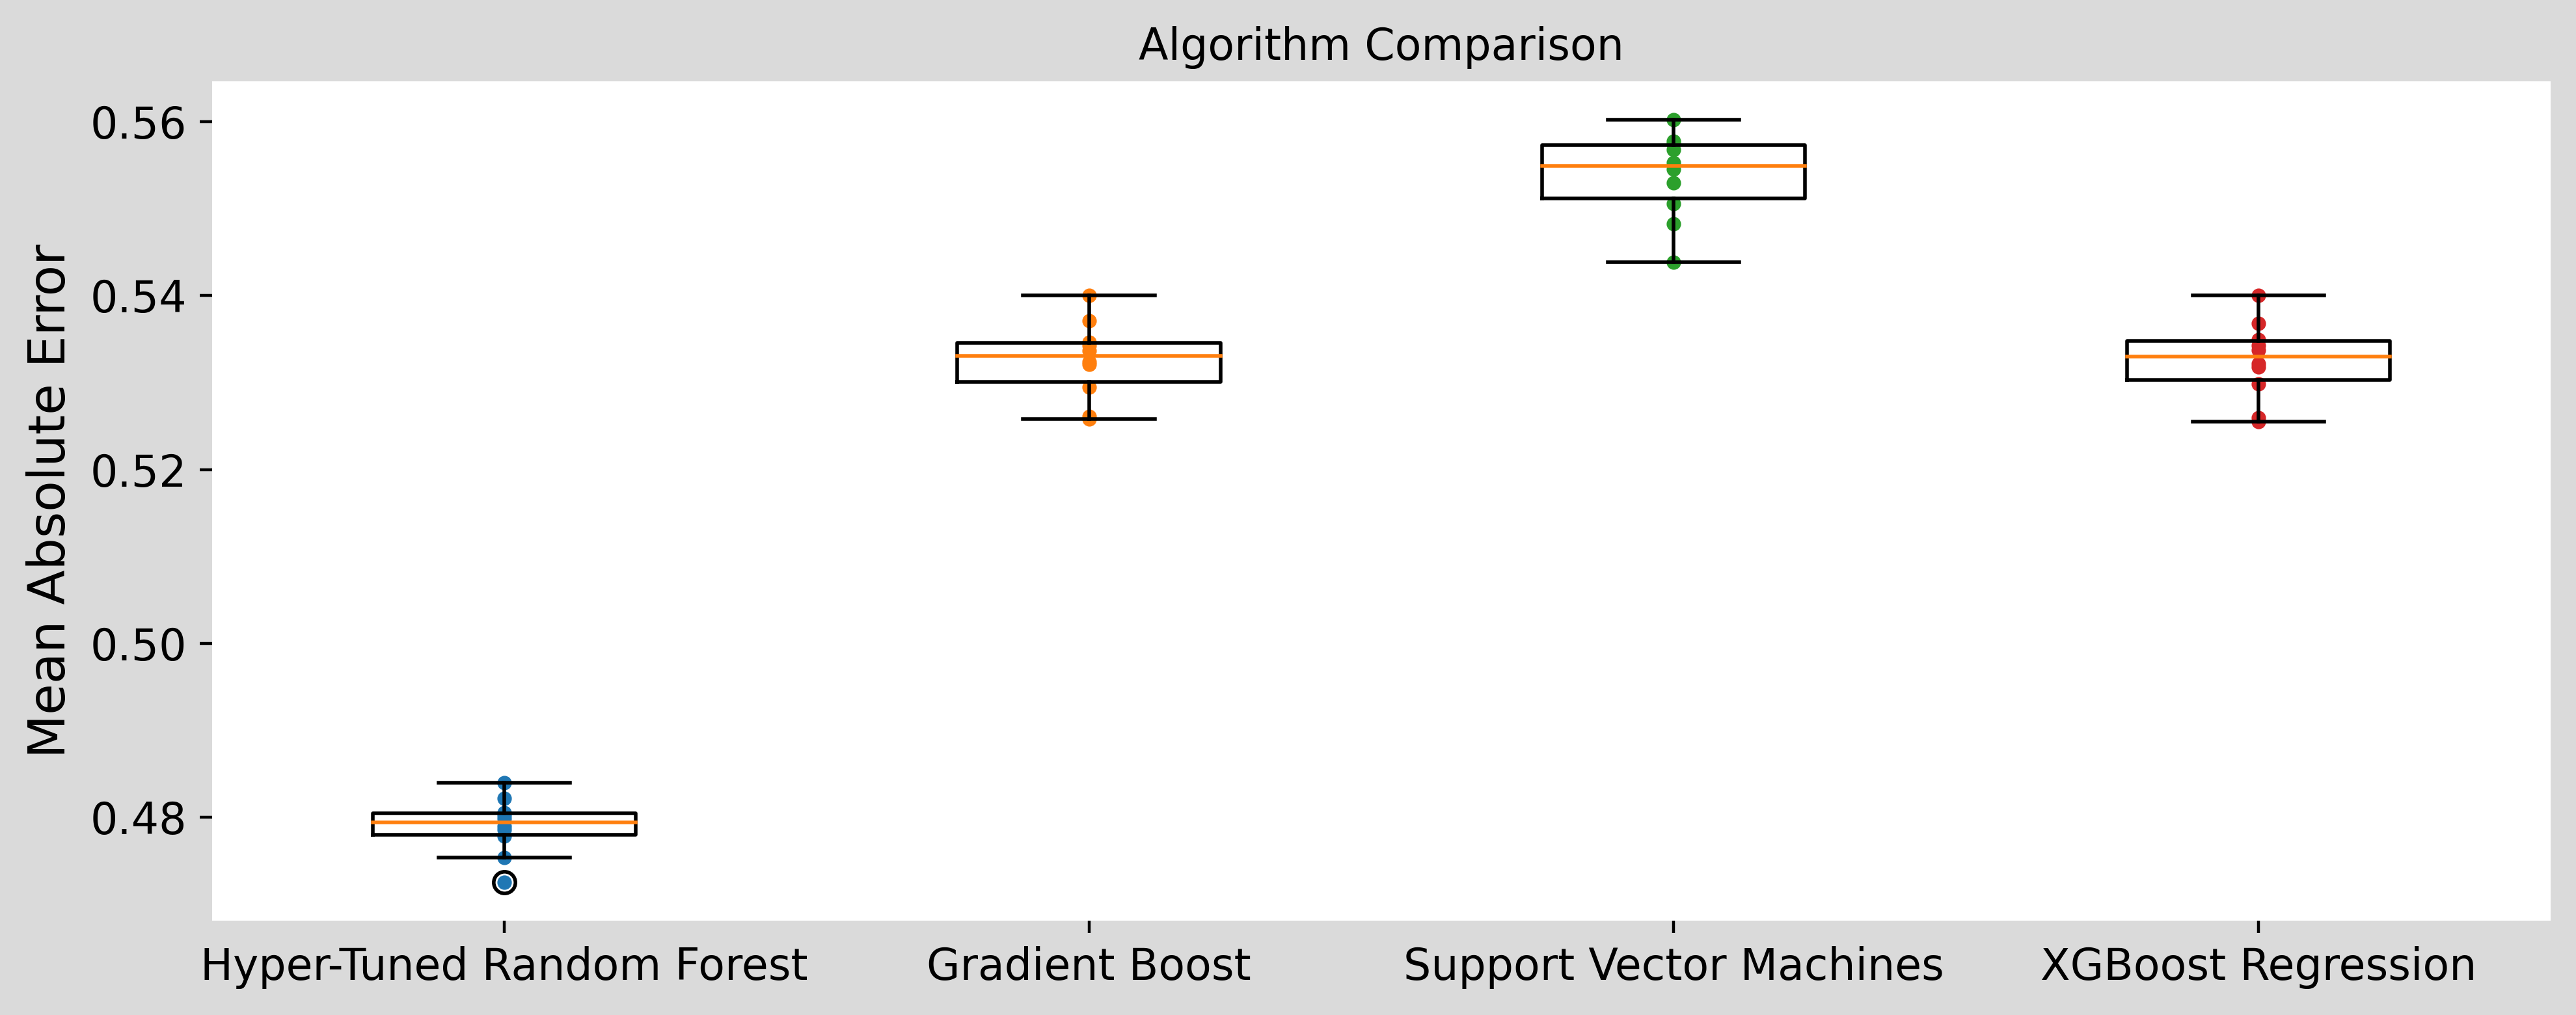

In [ ]:
fig = plt.figure(figsize=(10, 4), facecolor= '#dadada', dpi=400)


plt.plot([1]*10, forest_scores, ".")
plt.plot([2]*10, gbrt_scores, ".")
plt.plot([3]*10, svr_scores, ".")
plt.plot([4]*10, xgb_scores, ".")

plt.boxplot([forest_scores, gbrt_scores, svr_scores,xgb_scores], 
            labels=("Hyper-Tuned Random Forest", 'Gradient Boost', 'Support Vector Machines','XGBoost Regression'))

plt.ylabel("Mean Absolute Error", fontsize=14)
plt.title('Algorithm Comparison')


# Remove the splines 
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.tight_layout() # Makes it better looking specially on laptops

# to save the fig
#fig.savefig('algcomparison.png',bbox_inches='tight', dpi=500, facecolor = '#dadada')

plt.show()

## R2 Score

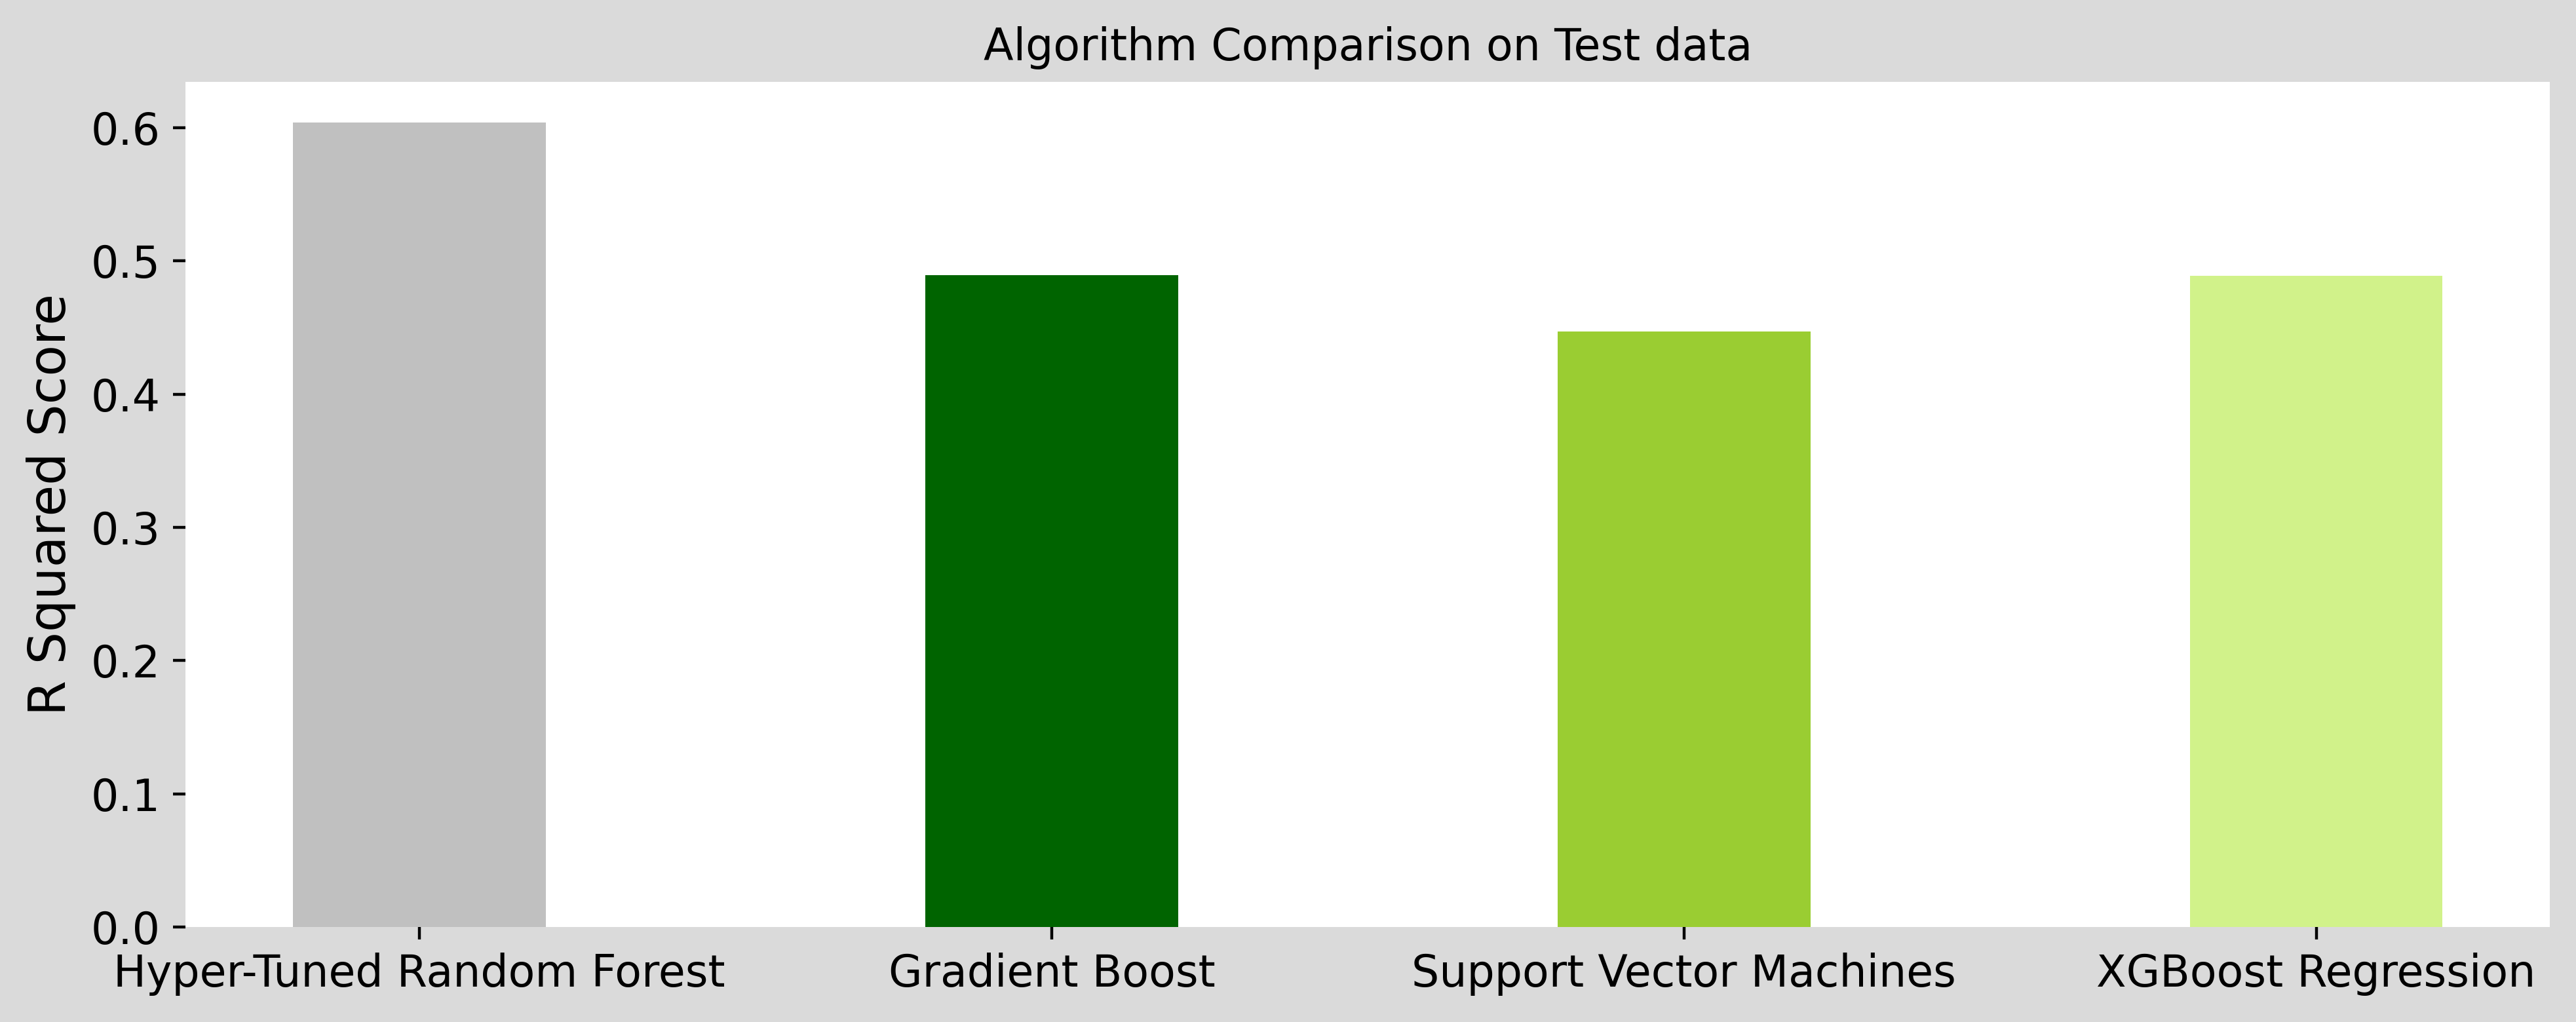

In [ ]:
forest_r2_score = r2_score(y_test, forest.predict(X_test))
gbrt_r2_score = r2_score(y_test, gbrt.predict(X_test))
svr_r2_score = r2_score(y_test, svr.predict(X_test))
xgb_r2_score = r2_score(y_test, xgb_reg.predict(X_test))


fig = plt.figure(figsize=(10, 4), facecolor= '#dadada', dpi=400)

data = {'Hyper-Tuned Random Forest':forest_r2_score, 
        'Gradient Boost':gbrt_r2_score, 
        'Support Vector Machines':svr_r2_score,
        'XGBoost Regression':xgb_r2_score}

courses = list(data.keys())
values = list(data.values())

plt.bar(courses, values,color=['silver', 'darkgreen', 'yellowgreen', '#d1f28a' ], width = 0.4)

plt.ylabel("R Squared Score", fontsize=14)
plt.title('Algorithm Comparison on Test data')


# Remove the splines 
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.tight_layout() # Makes it better looking specially on laptops

# to save the fig
#fig.savefig('algcomparison.png',bbox_inches='tight', dpi=500, facecolor = '#dadada')

plt.show()

In [ ]:
import joblib
# save the model to disk
filename = 'finalized_model.pkl'
joblib.dump(forest_reg, filename)

['finalized_model.pkl']

## *Question: Search factors affecting the rise in prices*

In [ ]:
forest.feature_importances_

array([3.35837612e-03, 2.54949191e-02, 4.25675110e-03, 3.38553932e-01,
       4.14884630e-02, 7.69689274e-02, 3.03542755e-02, 2.18644007e-02,
       4.49035020e-02, 3.53083583e-02, 4.35881547e-03, 5.81524045e-02,
       2.90053043e-03, 4.04691184e-03, 1.28352061e-02, 1.17063498e-02,
       4.06787605e-03, 7.72469222e-03, 1.73127659e-03, 6.88864924e-03,
       4.67770449e-03, 5.41977397e-03, 1.81064760e-03, 5.86192574e-03,
       2.77250266e-03, 1.58296074e-03, 1.47313714e-03, 2.18955968e-03,
       1.63121263e-03, 2.19123558e-03, 1.67889542e-03, 1.42852110e-03,
       2.16994363e-03, 3.78296056e-03, 2.07743909e-03, 2.29468281e-02,
       1.12200816e-01, 3.57035967e-03, 3.75715444e-02, 7.49971312e-04,
       5.80514664e-04, 2.37557291e-03, 6.85160092e-04, 5.26643753e-04,
       6.14898724e-04, 1.20944247e-03, 8.41753216e-04, 7.38465454e-04,
       1.12379179e-03, 6.52339746e-04, 7.35805590e-04, 1.19471692e-03,
       5.32422722e-04, 6.02980357e-04, 8.48528081e-04, 9.68453886e-04,
      

In [ ]:
ft_weights_forest_reg = pd.DataFrame(forest_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_forest_reg.sort_values('weight', inplace=True)
ft_weights_forest_reg

,weight
room_type_Shared room,0.000366
time_since_last_review_2-8 weeks,0.000524
review_scores_communication_0-8/10,0.000825
time_since_first_review_6-12 months,0.000861
review_scores_accuracy_0-8/10,0.000930
...,...
minimum_nights,0.043851
number_of_reviews,0.066657
room_type_Entire home/apt,0.103469
host_days_active,0.116862


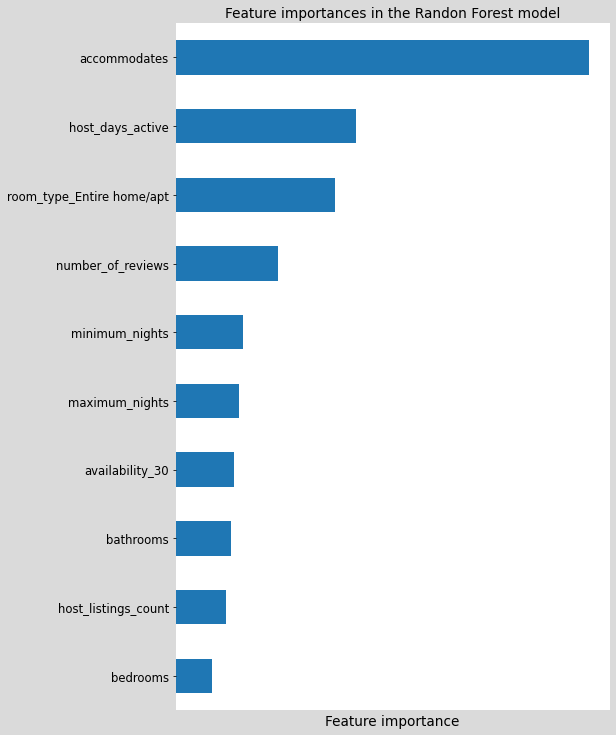

In [ ]:
fig = plt.figure(figsize=(8, 13), facecolor= '#dadada', dpi=70)
# plotting first 40 important features
ft_weights_forest_reg['weight'].tail(10).plot(kind='barh')
plt.title("Feature importances in the Randon Forest model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.xticks([])
# Remove the splines 
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)